# 1. 사전 준비

## 1.1 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from glob import glob
import glob
from typing import *
from IPython.display import Image as IPImage
from sklearn.model_selection import train_test_split
import random
import os
import shutil
from PIL import Image as Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import ConcatDataset
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F

## 1.2 구글 드라이브 마운트

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile

from_file_path = '/content/drive/MyDrive/real-and-fake-face-detection-master.zip'  # 복사할 파일
to_file_path = '/content/real-and-fake-face-detection-master.zip'  # 복사 위치

# 파일 복사
shutil.copy(from_file_path, to_file_path)

# 압축 해제
with zipfile.ZipFile(to_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/') # 압축 해제 위치

# 2. DataFrame 생성

In [4]:
# 파일 경로 가져오기 및 DataFrame 생성
image_paths = glob.glob('/content/real-and-fake-face-detection-master/dataset/training/*/*.jpg')
df = pd.DataFrame({'path': image_paths})

# 레이블 추출 및 CSV 저장
df['label'] = df['path'].apply(lambda x: os.path.basename(os.path.dirname(x)))
df.to_csv('train_data.csv', index=False)

# 학습 데이터셋 불러오기
origin_train_df = pd.read_csv('train_data.csv')
print(origin_train_df)

                                                   path label
0     /content/real-and-fake-face-detection-master/d...  fake
1     /content/real-and-fake-face-detection-master/d...  fake
2     /content/real-and-fake-face-detection-master/d...  fake
3     /content/real-and-fake-face-detection-master/d...  fake
4     /content/real-and-fake-face-detection-master/d...  fake
...                                                 ...   ...
1432  /content/real-and-fake-face-detection-master/d...  real
1433  /content/real-and-fake-face-detection-master/d...  real
1434  /content/real-and-fake-face-detection-master/d...  real
1435  /content/real-and-fake-face-detection-master/d...  real
1436  /content/real-and-fake-face-detection-master/d...  real

[1437 rows x 2 columns]


In [5]:
# 파일 경로 가져오기 및 DataFrame 생성
test_image_paths = glob.glob('/content/real-and-fake-face-detection-master/dataset/test/*/*.jpg')
tdf = pd.DataFrame({'path': test_image_paths})

# 레이블 추출
tdf['label'] = tdf['path'].apply(lambda x: os.path.basename(os.path.dirname(x)))

# CSV 파일로 저장
tdf.to_csv('test_data.csv', index=False)

## 2.1 검증 데이터셋 생성

In [6]:
# train 데이터셋을 8:2로 분할
train_df, valid_df = train_test_split(
    origin_train_df,
    test_size=0.2,
    random_state=0,
    shuffle=True,
    stratify=origin_train_df["label"],
)

# 3. 딥러닝 모델 구조

In [7]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        img = Image.open(img_name).convert('RGB')
        label = 0 if self.dataframe.iloc[idx, 1] == 'real' else 1
        if self.transform:
            img = self.transform(img)
        return img, label

        if self.transform:
            img = self.transform(img)

        return img, label

In [8]:
def compute_overall_mean_std(dfs):
    all_pixels = {0: [], 1: [], 2: []}

    for df in dfs:
        for index, row in df.iterrows():
            img_path = row['path']
            img = Image.open(img_path)
            img_np = np.array(img)

            for i in range(3): # RGB 채널
                channel_pixels = img_np[:, :, i].ravel().tolist()  # 각 채널의 모든 픽셀 값을 수집
                all_pixels[i].extend(channel_pixels)

    means = [np.mean(all_pixels[i]) for i in range(3)]
    stds = [np.std(all_pixels[i]) for i in range(3)]

    return means, stds

# 미리 계산해둔 값 사용
channel_means = [193.67807472479592, 111.60517909723688, 118.44033090803525]
channel_stds = [63.00208387441839, 87.1299016633704, 71.00312754293988]

print("Overall Data: Mean -", channel_means, "Std -", channel_stds)

Overall Data: Mean - [193.67807472479592, 111.60517909723688, 118.44033090803525] Std - [63.00208387441839, 87.1299016633704, 71.00312754293988]


In [9]:
# 채널 평균 및 표준편차를 0~1 사이의 값으로 정규화
normalized_channel_means = [x / 255 for x in channel_means]
normalized_channel_stds = [x / 255 for x in channel_stds]

# 배치 사이즈 설정
batch_size = 32

# 학습용 데이터 증강 변환 정의
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # 약간 큰 크기로 리사이즈
    transforms.RandomCrop((224, 224)),  # 랜덤 크롭
    transforms.RandomHorizontalFlip(),  # 랜덤 수평 뒤집기
    transforms.RandomRotation(10),  # 랜덤 회전 (-10도에서 10도 사이)
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 색상 변조
    transforms.ToTensor(),
    transforms.Normalize(mean=normalized_channel_means, std=normalized_channel_stds),
])

# 검증 및 테스트용 변환 정의 (데이터 증강 없음)
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=normalized_channel_means, std=normalized_channel_stds),
])

# 데이터셋 로딩
train_dataset = CustomDataset(dataframe=train_df, transform=train_transform)
valid_dataset = CustomDataset(dataframe=valid_df, transform=eval_transform)
test_dataset = CustomDataset(dataframe=tdf, transform=eval_transform)

# 데이터 로더 설정 (변경 없음)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


ResNet18 모델 로드 및 파인튜닝

In [12]:
# 사전 학습된 ResNet18 모델 불러오기
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# 모델의 마지막 완전 연결 계층(fc)을 사용자 정의 계층으로 대체
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 2), # 이진분류
)

# 교차 엔트로피 손실 함수 초기화
criterion = nn.CrossEntropyLoss()

# 이진 교차 엔트로피 손실 함수 초기화
#criterion = nn.BCEWithLogitsLoss()


# 최적화 알고리즘으로 Adam 사용
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [16]:
# 전체 훈련 횟수 설정
num_epochs = 50
# 최고 검증 정확도 초기화
best_val_acc = 0.0
# 얼리 스타핑을 위한 조건 설정 (성능 향상이 없을 때 몇 에포크까지 기다릴지)
patience = 5
# 연속적으로 성능 향상이 없는 에포크 수를 추적
no_improve = 0

# 훈련 및 검증 손실을 추적하기 위한 리스트
train_losses = []
valid_losses = []

# 정해진 훈련 횟수만큼 반복
for epoch in range(num_epochs):

    model.train() # 모델을 훈련 모드로 설정
    running_loss = 0.0
    correct_train = 0
    total_train = 0

     # 훈련 데이터 로더를 통해 배치를 반복
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", dynamic_ncols=True):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() # 이전 반복에서 계산된 그래디언트를 초기화
        outputs = model(inputs) # 모델에 입력을 전달하여 출력을 계산

        # BCEWithLogitsLoss는 0, 1 레이블을 예상하지만,
        # 모델은 2개의 출력 뉴런을 가지므로, 이를 0 또는 1로 변환해야 합니다.
        # 가장 높은 확률을 가진 클래스 인덱스를 선택합니다.
        _, predicted = torch.max(outputs.data, 1)

        # loss = criterion(outputs, labels) # 손실 함수를 사용하여 손실 계산
        loss = criterion(outputs[:, 1], labels.float())  # 이진 분류를 위한 수정
        loss.backward() # 손실에 대한 그래디언트를 계산
        optimizer.step() # 옵티마이저를 사용하여 모델의 가중치를 업데이트

        running_loss += loss.item()  # 총 손실을 누적

        # _, predicted = torch.max(outputs.data, 1) # 예측 결과 계산 # 이 부분은 위로 이동되었습니다.
        total_train += labels.size(0) # 전체 레이블 수 업데이트
        correct_train += (predicted == labels).sum().item() # 정확한 예측 수 업데이트

    # 에포크별 훈련 정확도 및 손실 계산
    train_acc = correct_train / total_train
    train_loss = running_loss / len(train_loader)

    # Validate
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Get the raw output for the positive class (index 1)
            # This makes sure outputs and labels have the same shape
            loss = criterion(outputs[:, 1], labels.float())  # Select the output for the positive class (index 1) and convert to float

            running_val_loss += loss.item()

            # For accuracy calculation, you still need predictions based on both outputs
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_acc = correct_val / total_val
    val_loss = running_val_loss / len(valid_loader)

    # 손실 기록
    train_losses.append(train_loss)
    valid_losses.append(val_loss)

    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

    # 최고 검증 정확도를 갱신하고 모델 저장
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model_after.pth')
        no_improve = 0
    else:
        no_improve += 1 # 성능 향상이 없으면 no_improve 카운터 증가
        if no_improve >= patience:  # 설정한 얼리 스타핑 patience에 도달하면 학습을 중단합니다.
            print("Early stopping")
            break

print('Finished Training')

Epoch 1/50:   0%|          | 0/36 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1/50: 100%|██████████| 36/36 [00:19<00:00,  1.82it/s]


Train Loss: 0.6637, Train Accuracy: 0.5605, Validation Loss: 0.7023, Validation Accuracy: 0.5521


Epoch 2/50: 100%|██████████| 36/36 [00:19<00:00,  1.80it/s]


Train Loss: 0.6316, Train Accuracy: 0.6171, Validation Loss: 0.7021, Validation Accuracy: 0.5486


Epoch 3/50: 100%|██████████| 36/36 [00:21<00:00,  1.65it/s]


Train Loss: 0.6099, Train Accuracy: 0.6319, Validation Loss: 0.7076, Validation Accuracy: 0.5521


Epoch 4/50: 100%|██████████| 36/36 [00:20<00:00,  1.80it/s]


Train Loss: 0.5861, Train Accuracy: 0.6728, Validation Loss: 0.7055, Validation Accuracy: 0.5660


Epoch 5/50: 100%|██████████| 36/36 [00:20<00:00,  1.79it/s]


Train Loss: 0.5818, Train Accuracy: 0.6841, Validation Loss: 0.7050, Validation Accuracy: 0.5660


Epoch 6/50: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]


Train Loss: 0.5620, Train Accuracy: 0.6980, Validation Loss: 0.7195, Validation Accuracy: 0.5729


Epoch 7/50: 100%|██████████| 36/36 [00:21<00:00,  1.71it/s]


Train Loss: 0.5436, Train Accuracy: 0.7163, Validation Loss: 0.6971, Validation Accuracy: 0.5833


Epoch 8/50: 100%|██████████| 36/36 [00:20<00:00,  1.80it/s]


Train Loss: 0.5359, Train Accuracy: 0.7346, Validation Loss: 0.6995, Validation Accuracy: 0.5729


Epoch 9/50: 100%|██████████| 36/36 [00:20<00:00,  1.76it/s]


Train Loss: 0.5140, Train Accuracy: 0.7520, Validation Loss: 0.7122, Validation Accuracy: 0.5833


Epoch 10/50: 100%|██████████| 36/36 [00:20<00:00,  1.78it/s]


Train Loss: 0.4841, Train Accuracy: 0.7694, Validation Loss: 0.7256, Validation Accuracy: 0.5938


Epoch 11/50: 100%|██████████| 36/36 [00:19<00:00,  1.81it/s]


Train Loss: 0.4691, Train Accuracy: 0.7624, Validation Loss: 0.7235, Validation Accuracy: 0.6076


Epoch 12/50: 100%|██████████| 36/36 [00:21<00:00,  1.68it/s]


Train Loss: 0.4598, Train Accuracy: 0.7781, Validation Loss: 0.7092, Validation Accuracy: 0.6181


Epoch 13/50: 100%|██████████| 36/36 [00:20<00:00,  1.77it/s]


Train Loss: 0.4363, Train Accuracy: 0.7990, Validation Loss: 0.7397, Validation Accuracy: 0.6181


Epoch 14/50: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]


Train Loss: 0.4376, Train Accuracy: 0.7998, Validation Loss: 0.7383, Validation Accuracy: 0.6111


Epoch 15/50: 100%|██████████| 36/36 [00:21<00:00,  1.68it/s]


Train Loss: 0.3955, Train Accuracy: 0.8233, Validation Loss: 0.7410, Validation Accuracy: 0.6111


Epoch 16/50: 100%|██████████| 36/36 [00:19<00:00,  1.82it/s]


Train Loss: 0.3857, Train Accuracy: 0.8277, Validation Loss: 0.7194, Validation Accuracy: 0.6250


Epoch 17/50: 100%|██████████| 36/36 [00:20<00:00,  1.79it/s]


Train Loss: 0.3547, Train Accuracy: 0.8477, Validation Loss: 0.7583, Validation Accuracy: 0.6215


Epoch 18/50: 100%|██████████| 36/36 [00:19<00:00,  1.83it/s]


Train Loss: 0.3418, Train Accuracy: 0.8660, Validation Loss: 0.7392, Validation Accuracy: 0.6285


Epoch 19/50: 100%|██████████| 36/36 [00:20<00:00,  1.78it/s]


Train Loss: 0.3373, Train Accuracy: 0.8607, Validation Loss: 0.7777, Validation Accuracy: 0.6354


Epoch 20/50: 100%|██████████| 36/36 [00:21<00:00,  1.68it/s]


Train Loss: 0.3130, Train Accuracy: 0.8738, Validation Loss: 0.7436, Validation Accuracy: 0.6250


Epoch 21/50: 100%|██████████| 36/36 [00:21<00:00,  1.65it/s]


Train Loss: 0.3060, Train Accuracy: 0.8834, Validation Loss: 0.7635, Validation Accuracy: 0.6285


Epoch 22/50: 100%|██████████| 36/36 [00:21<00:00,  1.69it/s]


Train Loss: 0.2871, Train Accuracy: 0.8930, Validation Loss: 0.7360, Validation Accuracy: 0.6250


Epoch 23/50: 100%|██████████| 36/36 [00:20<00:00,  1.79it/s]


Train Loss: 0.2666, Train Accuracy: 0.9051, Validation Loss: 0.7498, Validation Accuracy: 0.6181


Epoch 24/50: 100%|██████████| 36/36 [00:20<00:00,  1.78it/s]


Train Loss: 0.2601, Train Accuracy: 0.9077, Validation Loss: 0.7940, Validation Accuracy: 0.6319
Early stopping
Finished Training


In [18]:
model.load_state_dict(torch.load('best_model_after.pth')) # Corrected file name to match the saved file
model.eval()

<ipython-input-18-666c7b67640e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_after.pth')) # Corrected file name to match the

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
# Validate
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predicted.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_predictions = np.concatenate(all_predictions)

conf_mat = confusion_matrix(all_labels, all_predictions)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


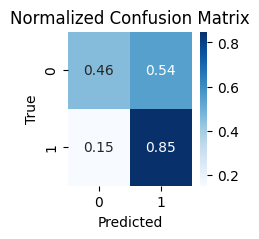

In [20]:
plt.figure(figsize=(2, 2))
sns.heatmap(conf_mat_normalized, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()
# real = 0 // fake = 1

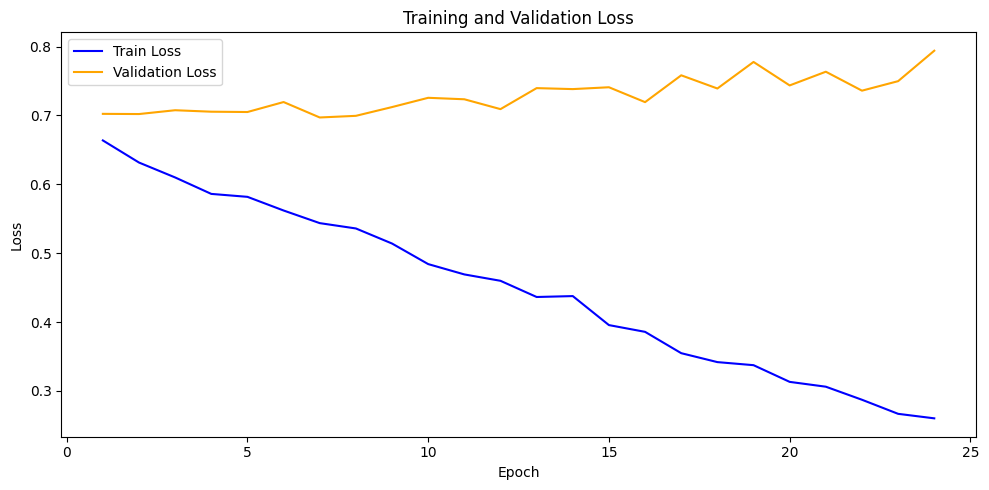

In [21]:
actual_epochs = len(train_losses)

plt.figure(figsize=(10, 5))
plt.plot(range(1, actual_epochs + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, actual_epochs + 1), valid_losses, label='Validation Loss', color='orange')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

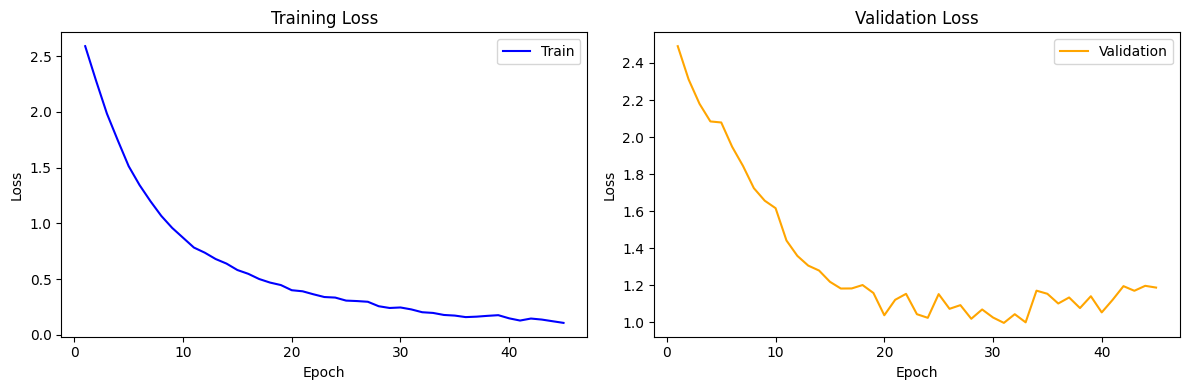

In [ ]:
actual_epochs = len(train_losses)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Train Loss 그래프
axes[0].plot(range(1, actual_epochs + 1), train_losses, label='Train', color='blue')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()

# Validation Loss 그래프
axes[1].plot(range(1, actual_epochs + 1), valid_losses, label='Validation', color='orange')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Validation Loss')
axes[1].legend()

# 그래프 출력
plt.tight_layout()
plt.show()

# 검증

In [22]:
def predict_image(model, image_path):
    # 평가모드 전환
    model.eval()

    # 이미지 처리
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # 변환 이미지 로드
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0)

    # 이미지 출력
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # 이미지 텐서 장치로 이동
    image_tensor = image_tensor.to(next(model.parameters()).device)

    # 예측
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)

    # 결과 출력
    result = "Real" if predicted.item() == 1 else "Fake"

    print(f"Prediction: {result}")
    return result

Enter location of image to predict: /content/real-and-fake-face-detection-master/dataset/face_pred/버츄얼 휴먼1.jpg


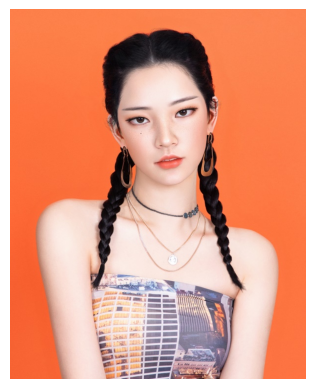

Prediction: Real


In [24]:
image_path = input("Enter location of image to predict: ")
prediction = predict_image(model, image_path)